In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [2]:

# --- Step 1: Load Data ---
def load_h5_data(directory, is_training=True, target_size=(256, 256), max_samples=None):
    images, masks = [], []
    sample_count = 0

    for filename in os.listdir(directory):
        if max_samples and sample_count >= max_samples:
            break
        if filename.endswith('.h5'):
            try:
                with h5py.File(os.path.join(directory, filename), 'r') as f:
                    image = f['image'][:]
                    if is_training:
                        mask = f['label'][:]

                    if image.ndim == 3:
                        for i in range(image.shape[0]):
                            img = tf.image.resize(np.expand_dims(image[i], -1), target_size).numpy()
                            images.append(img)
                            if is_training:
                                msk = tf.image.resize(np.expand_dims(mask[i], -1), target_size, method='nearest').numpy()
                                masks.append(np.squeeze(msk))
                    elif image.ndim == 2:
                        img = tf.image.resize(np.expand_dims(image, -1), target_size).numpy()
                        images.append(img)
                        if is_training:
                            msk = tf.image.resize(np.expand_dims(mask, -1), target_size, method='nearest').numpy()
                            masks.append(np.squeeze(msk))
                    sample_count += 1
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.uint8) if is_training else None
    return images, masks


In [3]:
# Load datasets
train_dir = 'E:/TEJA/NEW/cardiac/dataset/ACDC_preprocessed/ACDC_training_slices'
test_dir = 'E:/TEJA/NEW/cardiac/dataset/ACDC_preprocessed/ACDC_testing_volumes'

train_images, train_masks = load_h5_data(train_dir, is_training=True, target_size=(256, 256), max_samples=1500)
test_images, _ = load_h5_data(test_dir, is_training=False, target_size=(256, 256), max_samples=100)

# Normalize
train_images = train_images / np.max(train_images)
test_images = test_images / np.max(test_images)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {test_images.shape}")


Training shape: (1200, 256, 256, 1), Validation shape: (300, 256, 256, 1), Test shape: (1076, 256, 256, 1)


In [4]:
def attention_block(x, g, inter_channels):
    theta_x = layers.Conv2D(inter_channels, 1)(x)
    phi_g = layers.Conv2D(inter_channels, 1)(g)
    add = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi = layers.Conv2D(1, 1)(add)
    psi = layers.Activation('sigmoid')(psi)
    return layers.Multiply()([x, psi])

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_unet(input_shape=(256, 256, 1), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 1024)

    # Decoder + Attention
    u4 = layers.UpSampling2D((2, 2))(c5)
    att4 = attention_block(c4, u4, 512)
    u4 = layers.Concatenate()([u4, att4])
    c6 = conv_block(u4, 512)

    u3 = layers.UpSampling2D((2, 2))(c6)
    att3 = attention_block(c3, u3, 256)
    u3 = layers.Concatenate()([u3, att3])
    c7 = conv_block(u3, 256)

    u2 = layers.UpSampling2D((2, 2))(c7)
    att2 = attention_block(c2, u2, 128)
    u2 = layers.Concatenate()([u2, att2])
    c8 = conv_block(u2, 128)

    u1 = layers.UpSampling2D((2, 2))(c8)
    att1 = attention_block(c1, u1, 64)
    u1 = layers.Concatenate()([u1, att1])
    c9 = conv_block(u1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs, outputs)
    return model


In [5]:

# Instantiate model
model = attention_unet(input_shape=(256, 256, 1), num_classes=4)

# Print model architecture summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 128)     │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 128)     │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 32,448,904 (123.78 MB)

 Trainable params: 32,437,128 (123.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [6]:

# EarlyStopping: stop if no improvement for 10 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Learning Rate Decay: Exponential decay every 10 epochs
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.8  # reduce LR by 20%
    return lr

lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# (Optional) Save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_attention_unet.h5",
    monitor='val_loss',
    save_best_only=True
)

# Compile the model
model = attention_unet(input_shape=(256, 256, 1), num_classes=4)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=8,
    callbacks=[early_stop, lr_decay, checkpoint],
    verbose=1
)


Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8621 - loss: 0.5114   

150/150 ━━━━━━━━━━━━━━━━━━━━ 1983s 13s/step - accuracy: 0.8627 - loss: 0.5097 - val_accuracy: 0.2564 - val_loss: 1.9286 - learning_rate: 0.0010
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9774 - loss: 0.0804   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2137s 14s/step - accuracy: 0.9774 - loss: 0.0803 - val_accuracy: 0.9640 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9880 - loss: 0.0396   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2245s 15s/step - accuracy: 0.9880 - loss: 0.0396 - val_accuracy: 0.9723 - val_loss: 0.1328 - learning_rate: 0.0010
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9913 - loss: 0.0266   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2329s 16s/step - accuracy: 0.9913 - loss: 0.0266 - val_accuracy: 0.9832 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9921 - loss: 0.0231   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2238s 15s/step - accuracy: 0.9921 - loss: 0.0231 - val_accuracy: 0.9900 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 2118s 14s/step - accuracy: 0.9936 - loss: 0.0179 - val_accuracy: 0.9810 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9937 - loss: 0.0170   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2099s 14s/step - accuracy: 0.9938 - loss: 0.0170 - val_accuracy: 0.9924 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9933 - loss: 0.0182   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2100s 14s/step - accuracy: 0.9933 - loss: 0.0182 - val_accuracy: 0.9935 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 9/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9941 - loss: 0.0155   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2097s 14s/step - accuracy: 0.9941 - loss: 0.0155 - val_accuracy: 0.9944 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 10/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 2136s 14s/step - accuracy: 0.9944 - loss: 0.0148 - val_accuracy: 0.9936 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 11/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 2096s 14s/step - accuracy: 0.9954 - loss: 0.0118 - val_accuracy: 0.9944 - val_loss: 0.0158 - learning_rate: 8.0000e-04
Epoch 12/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 2106s 14s/step - accuracy: 0.9961 - loss: 0.0099 - val_accuracy: 0.9951 - val_loss: 0.0150 - learning_rate: 8.0000e-04
Epoch 13/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9960 - loss: 0.0101   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2132s 14s/step - accuracy: 0.9960 - loss: 0.0101 - val_accuracy: 0.9953 - val_loss: 0.0127 - learning_rate: 8.0000e-04
Epoch 14/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9964 - loss: 0.0090   

150/150 ━━━━━━━━━━━━━━━━━━━━ 2095s 14s/step - accuracy: 0.9964 - loss: 0.0090 - val_accuracy: 0.9953 - val_loss: 0.0127 - learning_rate: 8.0000e-04
Epoch 15/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 2097s 14s/step - accuracy: 0.9962 - loss: 0.0094 - val_accuracy: 0.9894 - val_loss: 0.0430 - learning_rate: 8.0000e-04


In [7]:
# Save model after training (if not already saved via ModelCheckpoint)
model.save("final_attention_unet_model.h5")


In [8]:
import numpy as np

# Predict (adjust batch_size if needed for your CPU/RAM)
val_preds  = model.predict(X_val, batch_size=8, verbose=1)
test_preds = model.predict(test_images, batch_size=8, verbose=1)

# Convert softmax probabilities to class labels
val_pred_labels  = np.argmax(val_preds,  axis=-1).astype(np.uint8)   # (N_val, H, W)
test_pred_labels = np.argmax(test_preds, axis=-1).astype(np.uint8)   # (N_test, H, W)


38/38 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Discrete colormap for 4 classes
class_colors = ['black', 'red', 'blue', 'gold']  # 0:BG, 1:LV, 2:RV, 3:MYO
class_names  = ['BG', 'LV', 'RV', 'MYO']
cmap = ListedColormap(class_colors)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

legend_patches = [Patch(color=class_colors[i], label=f'{i}: {class_names[i]}') for i in range(4)]


C:\Users\PythonTeam\AppData\Local\Temp\ipykernel_1260\326921595.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


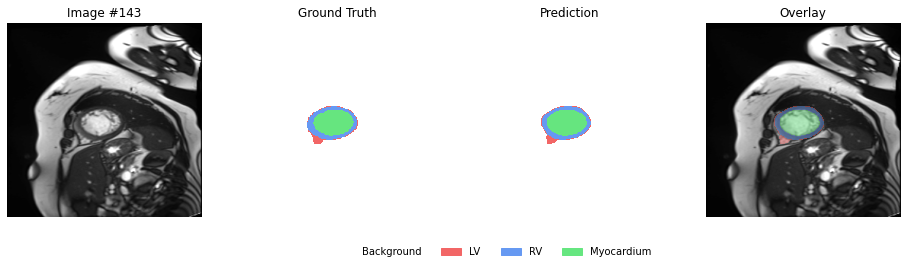

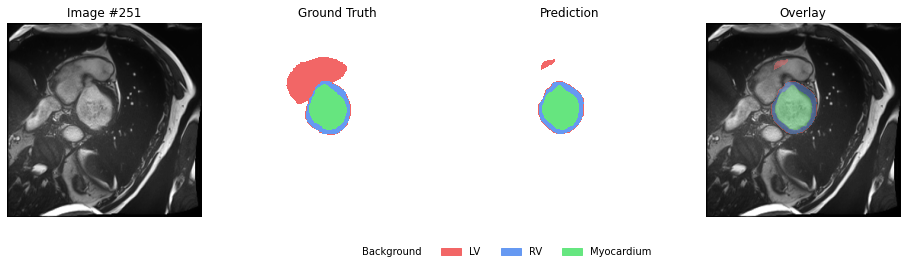

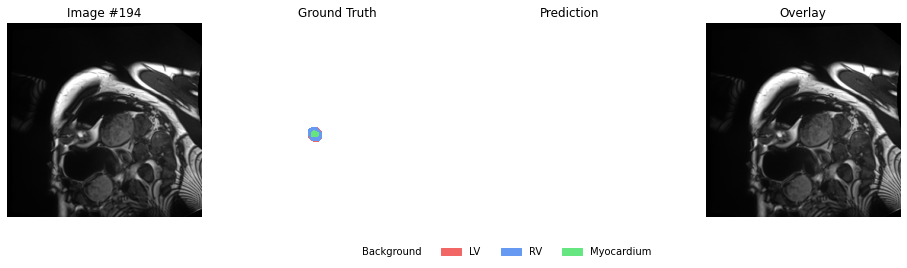

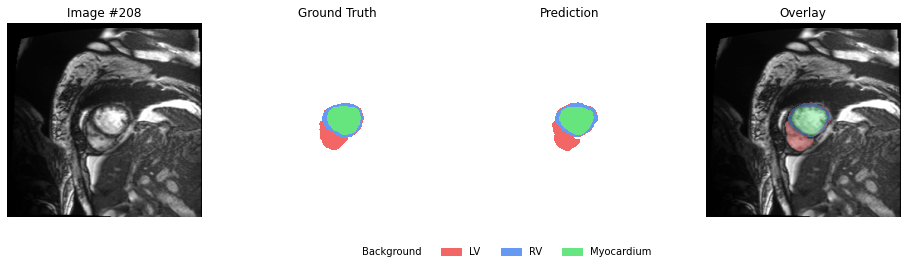

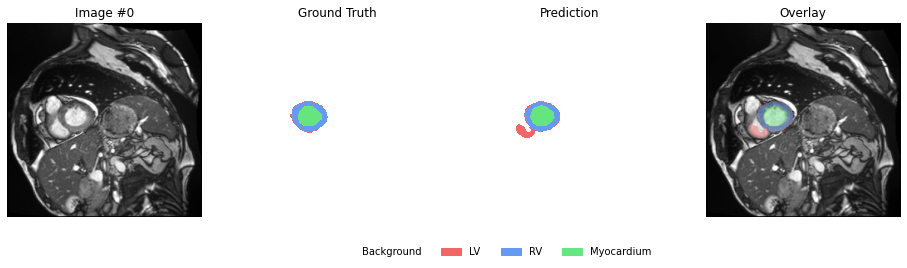

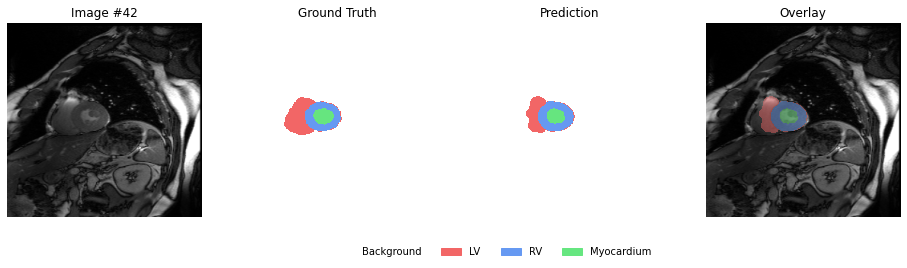

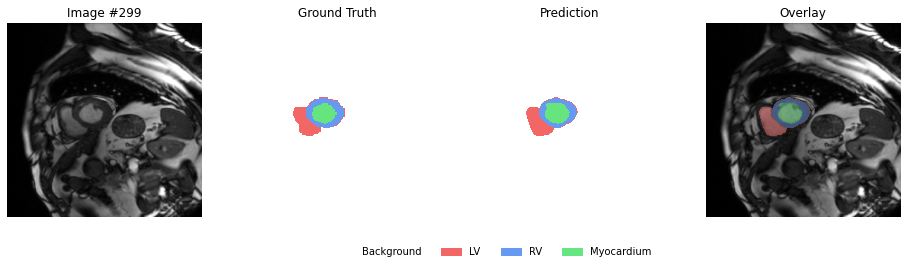

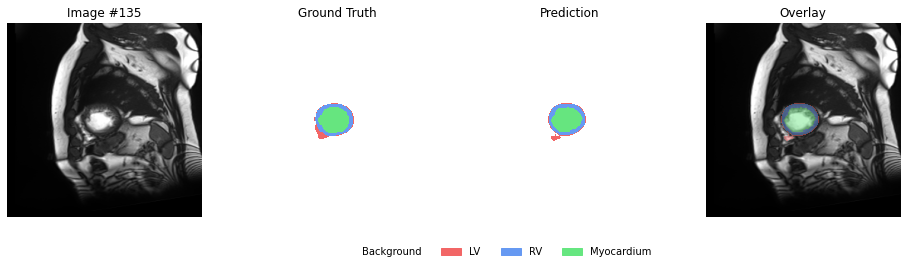

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def show_examples(images, gt_labels, pred_labels, indices=None, max_examples=6, alpha=0.45,
                  cmap=None, norm=None, legend_patches=None, class_names=None):
    """
    images:      (N, H, W, 1)
    gt_labels:   (N, H, W)   integer labels [0..C-1]
    pred_labels: (N, H, W)   integer labels [0..C-1]
    """
    N = images.shape[0]
    if indices is None:
        k = min(max_examples, N)
        indices = np.random.choice(np.arange(N), size=k, replace=False)
    
    for i in indices:
        img  = images[i, :, :, 0]
        gt   = gt_labels[i]
        pred = pred_labels[i]

        # normalize grayscale to [0,1] for display
        if img.max() > 1.0:
            img = img / 255.0

        plt.figure(figsize=(16, 4))

        # 1) Image
        plt.subplot(1, 4, 1)
        plt.title(f"Image #{i}")
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # 2) Ground Truth
        plt.subplot(1, 4, 2)
        plt.title("Ground Truth")
        plt.imshow(gt, cmap=cmap, norm=norm)
        plt.axis('off')

        # 3) Prediction
        plt.subplot(1, 4, 3)
        plt.title("Prediction")
        plt.imshow(pred, cmap=cmap, norm=norm)
        plt.axis('off')

        # 4) Overlay
        plt.subplot(1, 4, 4)
        plt.title("Overlay")
        plt.imshow(img, cmap='gray')
        plt.imshow(pred, cmap=cmap, norm=norm, alpha=alpha)
        plt.axis('off')

        # Optional legend below the row
        if legend_patches is not None:
            plt.legend(handles=legend_patches, loc='lower center',
                       bbox_to_anchor=(-1.1, -0.25), ncol=min(len(legend_patches), 4),
                       frameon=False)

        plt.tight_layout()
        plt.show()

# Example: show 8 random validation examples
show_examples(X_val, y_val, val_pred_labels, max_examples=8,
              cmap=cmap, norm=norm, legend_patches=legend_patches)


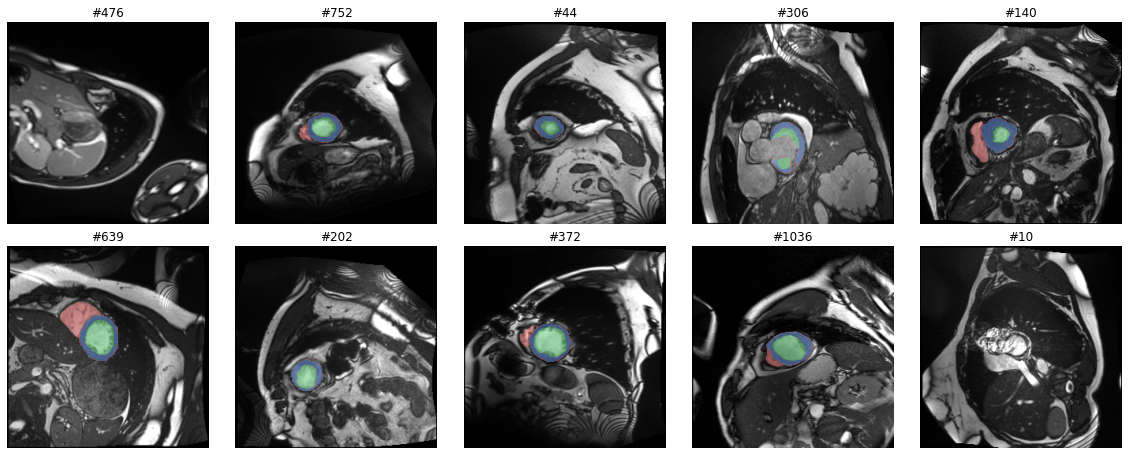

In [15]:
def show_grid(images, pred_labels, rows=2, cols=5, alpha=0.45, cmap=None, norm=None):
    N = min(rows*cols, images.shape[0])
    idxs = np.random.choice(np.arange(images.shape[0]), size=N, replace=False)
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    axes = axes.flatten()
    for ax, i in zip(axes, idxs):
        img  = images[i, :, :, 0]
        if img.max() > 1.0:
            img = img / 255.0
        ax.imshow(img, cmap='gray')
        ax.imshow(pred_labels[i], cmap=cmap, norm=norm, alpha=alpha)
        ax.set_title(f"#{i}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example: grid on test set
show_grid(test_images, test_pred_labels, rows=2, cols=5, cmap=cmap, norm=norm)


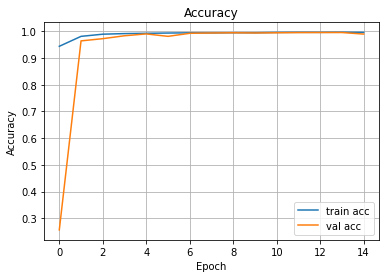

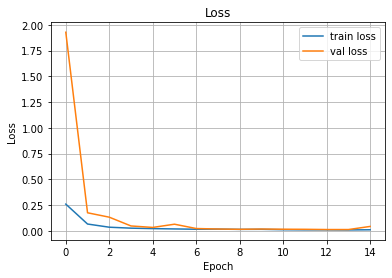

In [17]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    hist = history.history
    plt.figure(figsize=(6,4))
    if 'accuracy' in hist:
        plt.plot(hist['accuracy'], label='train acc')
    if 'val_accuracy' in hist:
        plt.plot(hist['val_accuracy'], label='val acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist['loss'], label='train loss')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='val loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend(); plt.show()

plot_training_curves(history)


Per-class IoU : [0.99649688 0.82645612 0.80083454 0.91044005]
Per-class Dice: [0.99824537 0.90498328 0.8894038  0.95312077]
mIoU=0.8836, mDice=0.9364


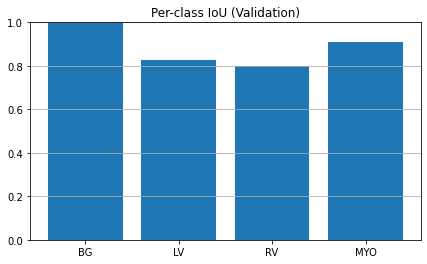

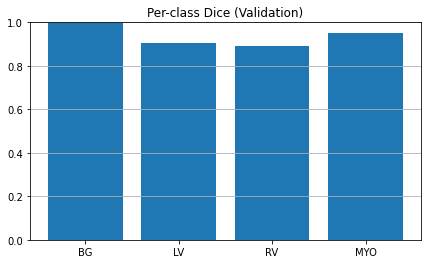

In [18]:
def compute_confusion(y_true, y_pred, num_classes=4):
    """
    y_true, y_pred: (N, H, W) integer labels
    returns confusion matrix C where C[t, p] = pixel count with true=t, pred=p
    """
    t = y_true.ravel().astype(np.int64)
    p = y_pred.ravel().astype(np.int64)
    mask = (t >= 0) & (t < num_classes)
    t = t[mask]; p = p[mask]
    cm = np.bincount(num_classes * t + p, minlength=num_classes**2).reshape(num_classes, num_classes)
    return cm

def iou_dice_from_confusion(cm):
    # cm[t, p]
    num_classes = cm.shape[0]
    iou = np.zeros(num_classes, dtype=np.float64)
    dice = np.zeros(num_classes, dtype=np.float64)
    for c in range(num_classes):
        TP = cm[c, c]
        FP = cm[:, c].sum() - TP
        FN = cm[c, :].sum() - TP
        denom_iou  = TP + FP + FN
        denom_dice = 2*TP + FP + FN
        iou[c]  = TP / denom_iou if denom_iou > 0 else np.nan
        dice[c] = (2*TP) / denom_dice if denom_dice > 0 else np.nan
    miou  = np.nanmean(iou)
    mdice = np.nanmean(dice)
    return iou, dice, miou, mdice

def plot_metrics_bars(values, labels, title, ylim=(0,1.0)):
    plt.figure(figsize=(7,4))
    plt.bar(np.arange(len(values)), values)
    plt.xticks(np.arange(len(values)), labels)
    plt.ylim(*ylim)
    plt.title(title); plt.grid(axis='y'); plt.show()

# Compute confusion on validation set
cm_val = compute_confusion(y_val, val_pred_labels, num_classes=4)
iou, dice, miou, mdice = iou_dice_from_confusion(cm_val)

print("Per-class IoU :", iou)
print("Per-class Dice:", dice)
print(f"mIoU={miou:.4f}, mDice={mdice:.4f}")

# Bar plots
plot_metrics_bars(iou,  class_names, "Per-class IoU (Validation)")
plot_metrics_bars(dice, class_names, "Per-class Dice (Validation)")


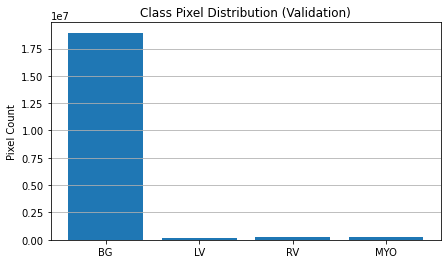

In [19]:
def plot_class_distribution(y, class_names):
    counts = [(y==i).sum() for i in range(len(class_names))]
    plt.figure(figsize=(7,4))
    plt.bar(np.arange(len(class_names)), counts)
    plt.xticks(np.arange(len(class_names)), class_names)
    plt.title("Class Pixel Distribution (Validation)")
    plt.ylabel("Pixel Count")
    plt.grid(axis='y')
    plt.show()

plot_class_distribution(y_val, class_names)


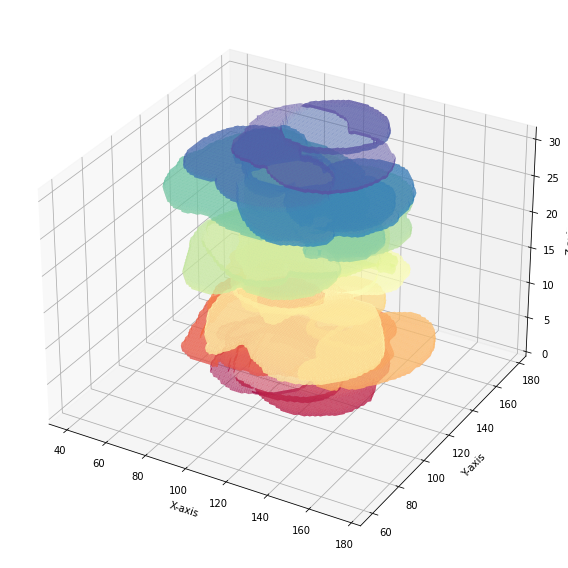

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

def plot_3d_mask(mask_3d, threshold=0.5, alpha=0.6):
    """
    mask_3d: (D, H, W) binary mask or integer labels (0..C-1)
    threshold: threshold for binary masks
    """
    # If it's multi-class, convert to binary for a specific class
    if mask_3d.ndim == 3 and mask_3d.max() > 1:
        mask_3d = (mask_3d > 0).astype(np.uint8)

    # Transpose to match axes (Z, Y, X)
    p = mask_3d.transpose(2, 1, 0)

    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    mesh = ax.plot_trisurf(verts[:,0], verts[:,1], faces, verts[:,2],
                           cmap='Spectral', lw=1, alpha=alpha)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    plt.tight_layout()
    plt.show()

# Example: choose first volume from validation set and predicted mask
volume_pred = val_pred_labels[:32]  # Take first 32 slices -> shape (D,H,W)
plot_3d_mask(volume_pred, threshold=0.5)
